In [2]:
import sqlite3
import json
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

def load_frame_from_mp4(mp4_path, frame_number=0):
    """
    Load a specific frame from an MP4 file.
    frame_number = 0 loads the first frame.
    """
    cap = cv2.VideoCapture(mp4_path)

    # Set the desired frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    success, frame = cap.read()
    cap.release()

    if success:
        # Convert BGR (OpenCV) to RGB (for PIL/Matplotlib)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(img)
    else:
        print(f"⚠️ Failed to read frame {frame_number} from {mp4_path}")
        return None
    
def return_highest_frame_number(image_dir, video_name):
    """
    Return the highest frame number from image filenames in the given directory that is a multiple of 30.
    Assumes filenames are in the format: "{video_name}_{frame_number}.jpg" or "{video_name}_{frame_number}.PNG"
    """
    video_name = os.path.splitext(video_name)[0]
    video_dir = os.path.join(image_dir, video_name)
    if not os.path.exists(video_dir):
        print(f"Directory {video_dir} does not exist.")
        return -1
    max_frame = -1
    for root, _, files in os.walk(video_dir):
        for file in files:
            # Check for .jpg or .PNG
            if file.endswith(".jpg") or file.endswith(".PNG"):
                ext = ".jpg" if file.endswith(".jpg") else ".PNG"
                parts = file.rsplit("_", 1)
                if len(parts) == 2 and parts[1].endswith(ext):
                    try:
                        frame_num = int(parts[1].replace(ext, ""))
                        if frame_num % 30 == 0 and frame_num > max_frame:
                            max_frame = frame_num
                    except ValueError:
                        continue
    print(f"Highest frame number: is {max_frame}")
    return max_frame

import sqlite3
import json
import os

DB_PATH = "/home/nele_pauline_suffo/ProcessedData/quantex_annotations/annotations.db"
TARGET_CATEGORIES = (3, 4, 5, 6, 7, 8, 12)

def load_annotations_from_db(video_name=None, image_id=None):
    """
    Query the annotations table and return a list of annotation dicts.

    - Always filters: outside = 0
    - Applies object_interaction = 'Yes' only for category_id in TARGET_CATEGORIES.
      For other category_ids, object_interaction is not checked.
    - Optionally filters by video_name (resolves to video_id) and/or image_id.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Resolve video_name -> video_id if provided
    video_id = None
    if video_name is not None:
        cursor.execute("SELECT id FROM videos WHERE file_name = ?", (video_name,))
        result = cursor.fetchone()
        if result:
            video_id = result[0]
        else:
            print(f"Video name '{video_name}' not found in videos table.")
            conn.close()
            return []

    base_query = "SELECT video_id, image_id, category_id, bbox FROM annotations"
    # Always require outside = 0
    conditions = ["outside = 0"]
    params = []

    # keep rows where either:
    #  - category_id NOT IN TARGET_CATEGORIES  (no object_interaction check)
    #  OR
    #  - category_id IN TARGET_CATEGORIES AND object_interaction = 'Yes'
    cat_list_str = ", ".join(str(c) for c in TARGET_CATEGORIES)
    conditions.append(
        f"(category_id NOT IN ({cat_list_str}) OR (category_id IN ({cat_list_str}) AND object_interaction = 'Yes'))"
    )

    if video_id is not None:
        conditions.append("video_id = ?")
        params.append(video_id)
    if image_id is not None:
        conditions.append("image_id = ?")
        params.append(image_id)

    if conditions:
        query = base_query + " WHERE " + " AND ".join(conditions)
    else:
        query = base_query

    cursor.execute(query, params)
    rows = cursor.fetchall()
    conn.close()

    # Convert rows to list of dicts
    annotations = []
    for row in rows:
        video_id_val, image_id_val, category, bbox_json = row
        # bbox might be JSON string (list) or comma-separated
        try:
            bbox = json.loads(bbox_json)
        except Exception:
            bbox = [float(x) for x in bbox_json.split(",")]
        annotations.append({
            'video_id': video_id_val,
            'frame_number': image_id_val,
            'category': category,
            'bbox': bbox,
        })
    return annotations

def plot_annotations(video_name, frame_number, annotations_table, image_folder, output_folder, video_folder=None):
    """
    Plot an image or extracted video frame and draw bounding boxes on it.
    """
    video_stem = os.path.splitext(video_name)[0]
    frame_number_padded = str(frame_number).zfill(6)

    # Try to find the image first
    image_filename_jpg = f"{video_stem}_{frame_number_padded}.jpg"
    image_filename_png = f"{video_stem}_{frame_number_padded}.PNG"
    image_path_jpg = os.path.join(image_folder, video_stem, image_filename_jpg)
    image_path_png = os.path.join(image_folder, video_stem, image_filename_png)

    if os.path.exists(image_path_jpg):
        image_path = image_path_jpg
        img = Image.open(image_path)
        print(f"✅ Found image: {image_path}")
    elif os.path.exists(image_path_png):
        image_path = image_path_png
        img = Image.open(image_path)
        print(f"✅ Found image: {image_path}")
    else:
        print(f"⚠️ Image not found for frame {frame_number_padded}. Trying to load from video...")
        img = None

        # Try to extract frame from MP4
        mp4_path = os.path.join("/home/nele_pauline_suffo/ProcessedData/quantex_videos", f"{video_stem}.MP4")
        if os.path.exists(mp4_path):
            img = load_frame_from_mp4(mp4_path, frame_number)
        else:
            print(f"⚠️ Video file not found: {mp4_path}")

        if img is None:
            print("❌ Could not load frame from image or video.")
            return

    img_w, img_h = img.size
    fig, ax = plt.subplots(1, figsize=(img_w / 300, img_h / 300), dpi=150)
    ax.imshow(img)
    ax.axis('off')

    for ann in annotations_table:
        bbox = [float(x) for x in ann['bbox']]

        # Detect bbox format automatically
        if bbox[2] > bbox[0] and bbox[3] > bbox[1]:
            x, y, w, h = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
        else:
            x, y, w, h = bbox

        # Clamp to image
        x = max(0, min(x, img_w - 1))
        y = max(0, min(y, img_h - 1))
        w = min(w, img_w - x)
        h = min(h, img_h - y)

        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, str(ann['category']),
                color='white', fontsize=6, backgroundcolor='black')

    plt.show()

Highest frame number: is 25650
✅ Found image: /home/nele_pauline_suffo/ProcessedData/quantex_rawframes_cvat/quantex_at_home_id257511_2021_07_13_01/quantex_at_home_id257511_2021_07_13_01_000060.jpg


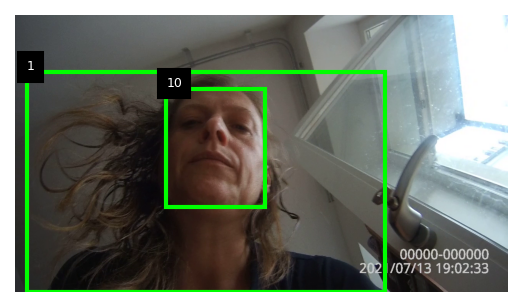

In [3]:
video_name = "quantex_at_home_id257511_2021_07_13_01.mp4"
output_dir = "/home/nele_pauline_suffo/ProcessedData/frame_validation"
image_dir = "/home/nele_pauline_suffo/ProcessedData/quantex_rawframes_cvat"
frame = return_highest_frame_number(image_dir, video_name)
frame = 60
annotations = load_annotations_from_db(video_name, frame)
plot_annotations(video_name, frame, annotations, image_dir, output_dir)

⚠️ Image not found for frame 000054. Trying to load from video...


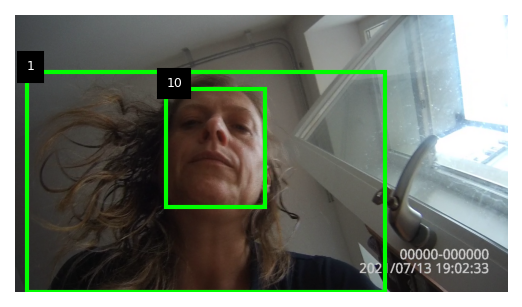

In [ ]:
frame = 54
image_dir = "/home/nele_pauline_suffo/ProcessedData/quantex_annotated_rawframes"
#image_dir = "/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed"
plot_annotations(video_name, frame, annotations, image_dir, output_dir)

In [88]:
annotations

[{'video_id': 42,
  'frame_number': 6120,
  'category': 1,
  'bbox': [1.0, 0.0, 326.3, 1110.5]}]

In [83]:
# for a folder named

In [10]:
import os

#quantex_at_home_id262565_2022_05_26_02
folder = "/home/nele_pauline_suffo/ProcessedData/quantex_rawframes_cvat/quantex_at_home_id262565_2022_05_26_01"
old_id = "id255237"
new_id = "id262565"

for filename in os.listdir(folder):
    if old_id in filename:
        new_filename = filename.replace(old_id, new_id)
        old_path = os.path.join(folder, filename)
        new_path = os.path.join(folder, new_filename)
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} -> {new_filename}")

Renamed: quantex_at_home_id255237_2022_05_26_01_005760.PNG -> quantex_at_home_id262565_2022_05_26_01_005760.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_005820.PNG -> quantex_at_home_id262565_2022_05_26_01_005820.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_005880.PNG -> quantex_at_home_id262565_2022_05_26_01_005880.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_005940.PNG -> quantex_at_home_id262565_2022_05_26_01_005940.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_006000.PNG -> quantex_at_home_id262565_2022_05_26_01_006000.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_006060.PNG -> quantex_at_home_id262565_2022_05_26_01_006060.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_006120.PNG -> quantex_at_home_id262565_2022_05_26_01_006120.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_006180.PNG -> quantex_at_home_id262565_2022_05_26_01_006180.PNG
Renamed: quantex_at_home_id255237_2022_05_26_01_006240.PNG -> quantex_at_home_id262565_2022_05_26_01_006

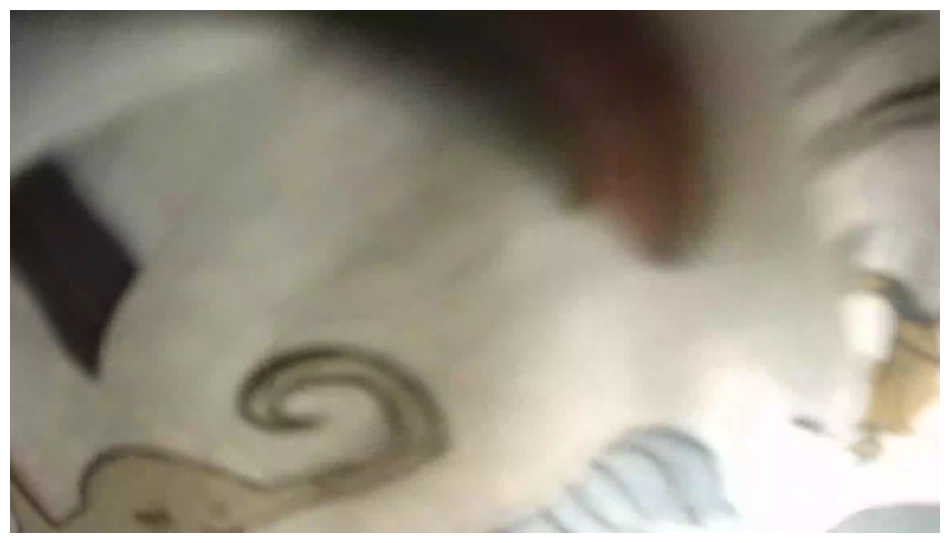

In [202]:
mp4_path = "/home/nele_pauline_suffo/ProcessedData/quantex_videos/quantex_at_home_id262565_2022_05_26_01.MP4"
frame_to_show = 1460

img = load_frame_from_mp4(mp4_path, frame_number=frame_to_show)

if img:
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()